## Analysis of days to late and late returns across media types
Another interesting property of a borrowing is the amount of days it is returned late.
This notebook is used to explore these possible correlations between amount of days an item is returned late and late returns across media types.

Most of the analysis is done with media types with at least 1000 borrowings. (Adjust the `MIN_BORROWINGS_PER_MEDIA_TYPE` variable in `03_data_cleaning.ipynb`)

Initialization
- import all dependencies
- read all borrowings from "borrowings" csv-file

In [59]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import plotly.express as px
import statsmodels.api as sm
from utils import setup_pandas, setup_plotting, log_pearson_spearman

input_file = Path('../dat/processed/borrowings_2019_2025_cleaned.csv')

data_frame = pd.read_csv(
    input_file,
    sep=';',
    quotechar='"',
    encoding='utf-8'
)

print(data_frame.shape)
data_frame.head()

(1888669, 21)


,issue_id,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Leihdauer,Anzahl_Verlängerungen,Verspätet,Tage_zu_spät,Sammlungszeichen/CCODE,Medientyp,Barcode,...,Autor,ISBN,Interessenkreis,Benutzerkategorie,Benutzer-Systemnummer,source_year,late_bool,open_days_leihdauer,max_allowed_open_days,weird_loan
0,56565,2019-01-02 00:00:00,2019-03-06 07:09:36,63.0,1,Nein,0.0,esac,Sachbuch,18143906,...,NaN,9783831904525,NaN,MPA,50.0,2019,False,0.0,56,False
1,56566,2019-01-02 00:00:00,2019-03-06 07:09:38,63.0,1,Nein,0.0,esac,Sachbuch,18184110,...,"Bruschke, Gerhard",9783734205736,NaN,MPA,50.0,2019,False,0.0,56,False
2,56567,2019-01-02 00:00:00,2019-03-06 07:09:31,63.0,1,Nein,0.0,esac,Sachbuch,17202121,...,"Fründt, Hans-Jürgen",9783831730735,NaN,MPA,50.0,2019,False,0.0,56,False
3,56574,2019-01-07 00:00:00,2019-02-09 12:14:54,33.0,0,Nein,0.0,eslfantasy,Belletristik,15138046,...,"Sapkowski, Andrzej",9783423247542,Fantasy,A12,10445.0,2019,False,0.0,28,False
4,1000896,2019-01-08 00:00:00,2019-01-28 11:04:21,20.0,0,Nein,0.0,esach,Sachbuch,18506705,...,NaN,9783742601445,Lernhilfe - Deutsch,MZUL,1000014.0,2019,False,0.0,28,False


## Analysis of days to late and late returns across media types
Another interesting property of a borrowing is the amount of days it is returned late. Is there a correlation to late returns?

First we look at a basic table of properties regarding the amount of days an object was returned late.

### Column descriptions (days-late summary by media type)
- **relative_lateness_if_late**
  mean days late (if late) divided by the loan duration
- **mean_days_late_if_late**
  Average number of days late, conditional on the loan being late.
- **median_days_late_if_late**
  Median number of days late, conditional on the loan being late.
- **p75_days_late**
  75th percentile of days late **among late loans only**
- **p90_days_late**
  90th percentile of days late **among late loans only**
- **mean_days_late_per_loan_duration (%)**
  Average ratio of days late to total loan duration, expressing lateness relative to how long items were borrowed.

In [67]:
def p75_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 75) if len(numeric_series) > 0 else 0.0

def p90_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 90) if len(numeric_series) > 0 else 0.0


days_late_table = (
    data_frame
    .assign(
        late=lambda df: df["Verspätet"] == "Ja",
        days_late=lambda df: df["Tage_zu_spät"].clip(lower=0),
        days_late_per_loan_duration=lambda df: df["Tage_zu_spät"].clip(lower=0) / df["Leihdauer"],
        rel_late=lambda df: np.where(df["Leihdauer"] > 0, df["Tage_zu_spät"].clip(lower=0) / df["Leihdauer"],np.nan
                                     ),
    )
    .groupby("Medientyp")
    .agg(
        n_loans=("Leihdauer", "size"),
        late_rate=("late", "mean"),

        # basic properties
        mean=("days_late", "mean"),
        median=("days_late", "median"),
        max_days_late=("days_late", "max"),

        relative_lateness_if_late=("rel_late", lambda x: x[x > 0].mean()),

        # if late
        mean_days_late_if_late=("days_late", lambda x: x[x > 0].mean()),
        median_days_late_if_late=("days_late", lambda x: x[x > 0].median()),
        p75_days_late=("Tage_zu_spät", p75_if_late),
        p90_days_late=("Tage_zu_spät", p90_if_late),

        # relative lateness
        mean_days_late_per_loan_duration=("days_late_per_loan_duration", "mean")

    )
    .reset_index()
    .assign(
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
        mean_days_late_per_loan_duration=lambda df: (df["mean_days_late_per_loan_duration"] * 100).round(2),
        relative_lateness_if_late=lambda df: (df["relative_lateness_if_late"] * 100).round(2),
    )
    .sort_values("late_rate", ascending=False)
)

display(days_late_table)


,Medientyp,n_loans,late_rate,mean,median,max_days_late,relative_lateness_if_late,mean_days_late_if_late,median_days_late_if_late,p75_days_late,p90_days_late,mean_days_late_per_loan_duration
11,Sprachkurse,6261,7.83,0.811053,0.0,151.0,9.48,10.363265,5.0,13.0,24.1,0.78
7,Konsolenspiel,6939,6.24,0.571264,0.0,173.0,12.01,9.154734,4.0,10.0,20.8,0.78
2,DVD,243468,5.83,0.391431,0.0,230.0,15.39,6.711811,4.0,7.0,14.0,0.91
9,Sachbuch,315732,5.37,0.398240,0.0,222.0,8.77,7.411116,4.0,9.0,16.0,0.48
10,Spiele,17779,5.32,0.399179,0.0,116.0,10.01,7.502114,5.0,10.0,17.0,0.55
12,Tonie,18206,4.78,0.290728,0.0,145.0,10.04,6.076923,3.0,7.0,14.0,0.49
3,Fremdsprachige Belletristik,24089,4.56,0.394288,0.0,202.0,10.61,8.642402,5.0,9.0,19.0,0.49
6,Kinder u. Jugendbuch,623096,4.43,0.326442,0.0,219.0,10.62,7.368945,4.0,9.0,16.0,0.47
13,Zeitschriften,12058,3.58,0.218278,0.0,49.0,8.37,6.092593,4.0,8.0,14.0,0.30
5,Kinder u. Jugend-CD,162850,3.00,0.229450,0.0,215.0,9.80,7.649130,4.0,8.0,17.0,0.30


If we look at the median number of days late, using an outlier resistant metric, we see that the number of days late does not vary much across media types. For most media types, a late return is typically about 4 to 5 days overdue. There are only small exceptions, with medians around 3 days or 6 days.

To get a better overview, we also create a boxplot for each media type.

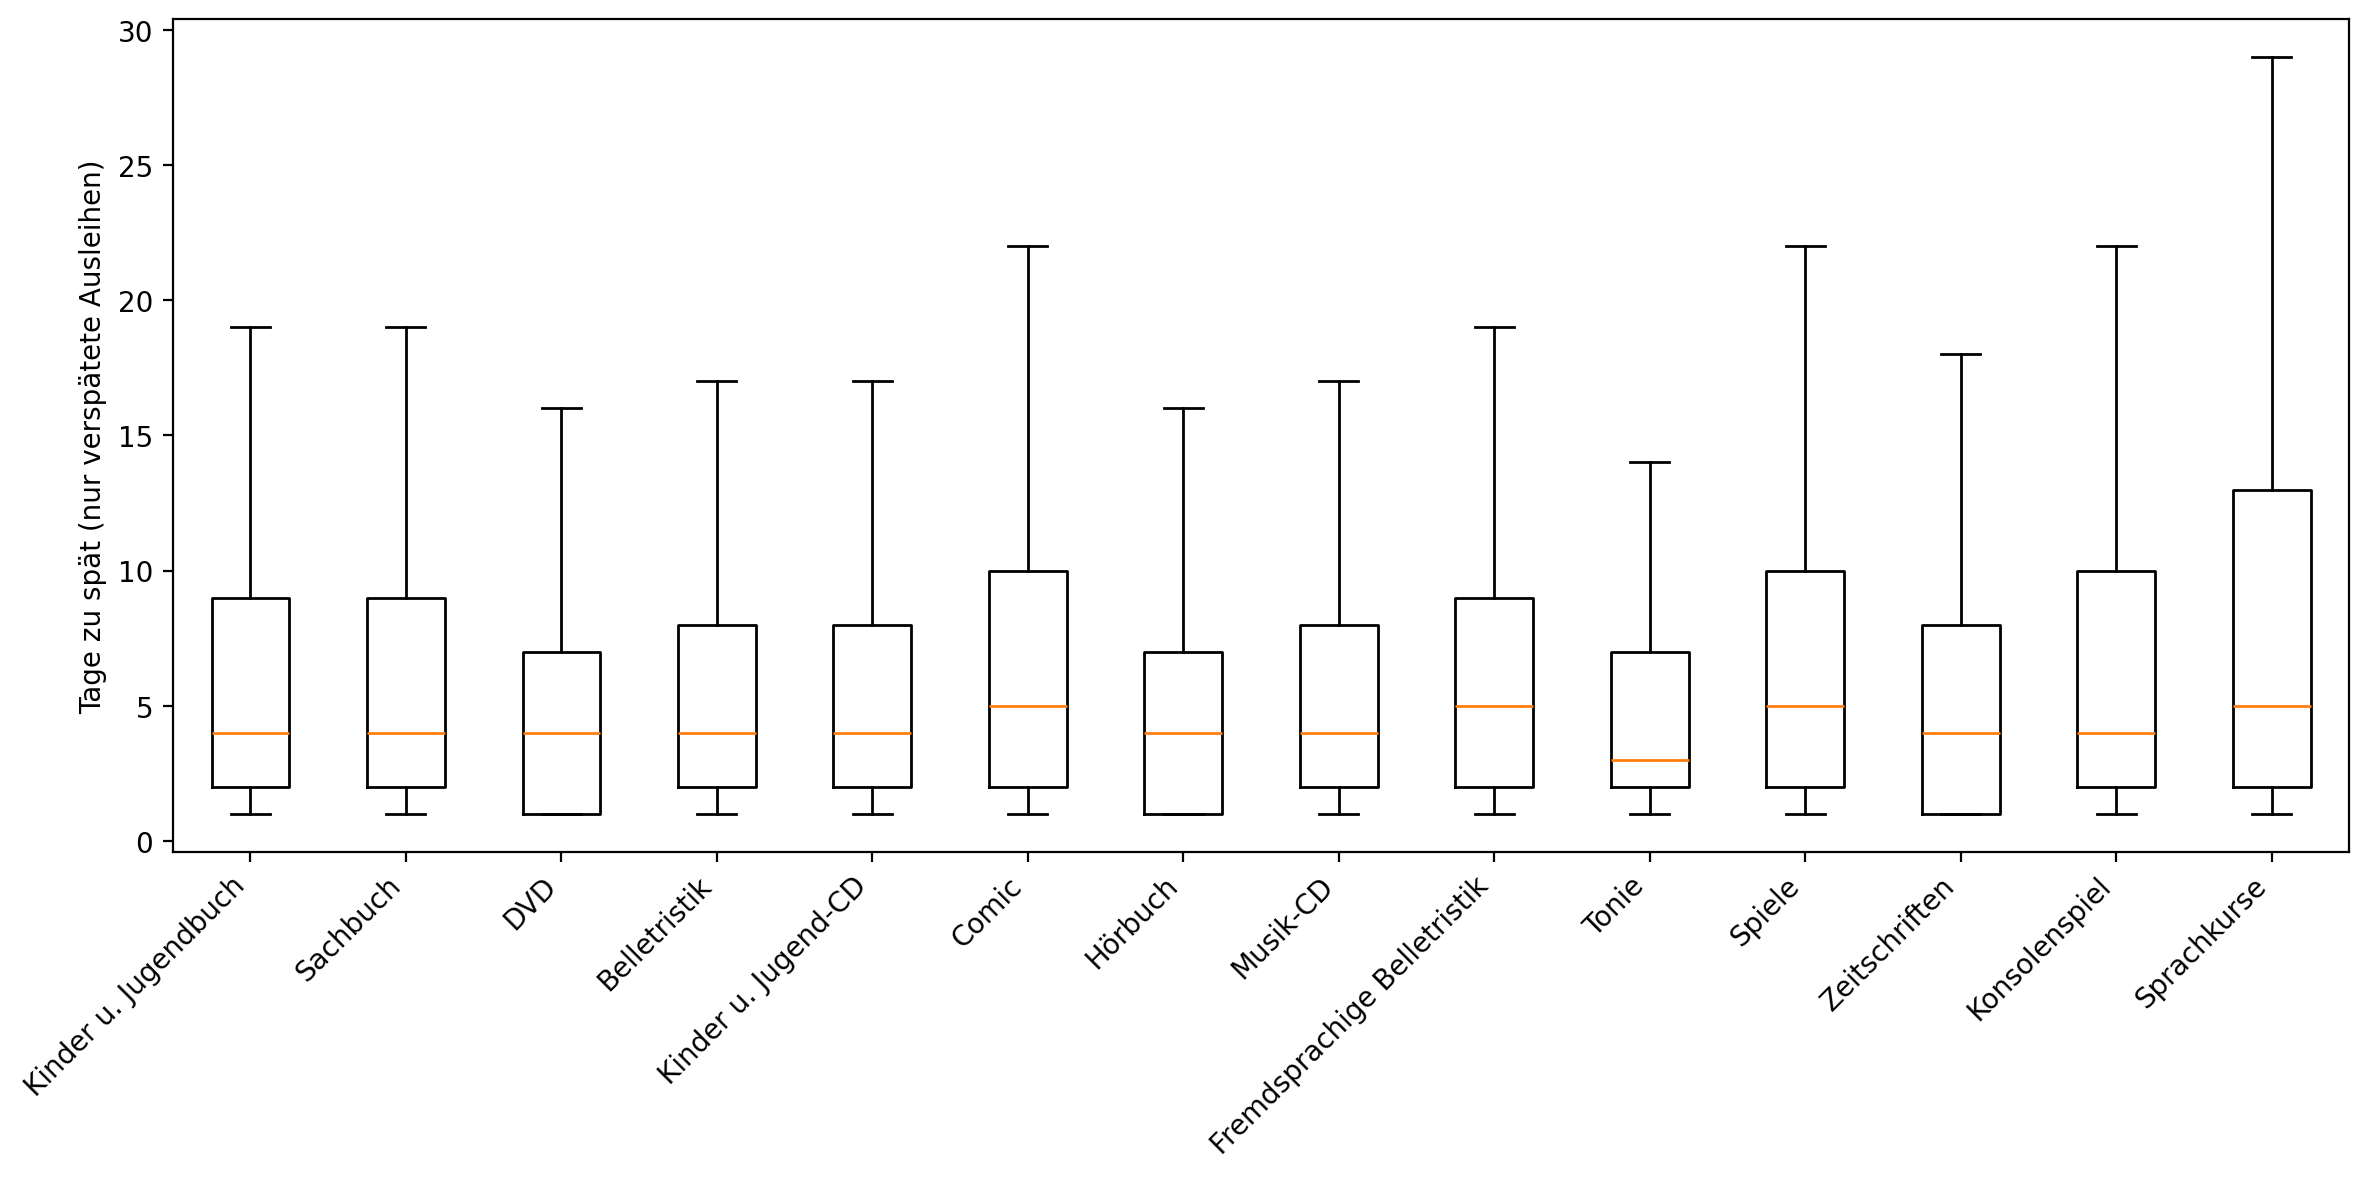

In [69]:
late_data = (
    data_frame
    .assign(
        late=lambda d: d["Verspätet"] == "Ja",
        days_late=lambda d: d["Tage_zu_spät"].clip(lower=0)
    )
)
order = late_data["Medientyp"].value_counts().index.tolist()
late_data = late_data[late_data["days_late"] > 0].copy()

data = [late_data.loc[late_data["Medientyp"] == m, "days_late"].values for m in order]

plt.figure(figsize=(12, 6))
plt.boxplot(
    data,
    tick_labels=order,
    showfliers=False
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Tage zu spät (nur verspätete Ausleihen)")
plt.tight_layout()
plt.show()


## Summary
Across media types, the typical lateness of late loans is fairly stable at around 4–5 days, while differences between media types mainly show up in the variability and the upper tail, with Sprachkurse exhibiting the strongest long-delay tail